In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import joblib
import os
import numpy as np
from PIL import Image
import random


In [2]:
train_path = r"E:\marine-animals-dataset\versions\1\train"
test_path = r"E:\marine-animals-dataset\versions\1\test"

In [3]:
# Image size for InceptionV3
img_size = (299, 299)

def preprocess_input(x):
    """Manual implementation of InceptionV3 preprocessing"""
    x = x.astype(np.float32)
    x /= 127.5
    x -= 1.0
    return x

def manual_image_augmentation(img):
    """Manual implementation of the augmentation parameters"""
    # Convert to PIL Image for easier transformations
    pil_img = Image.fromarray(img.astype(np.uint8))
    
    # Rotation (-30 to +30 degrees)
    if random.random() < 0.5:  # 50% chance like rotation_range=30
        angle = random.uniform(-30, 30)
        pil_img = pil_img.rotate(angle, resample=Image.BILINEAR, fillcolor=0)
    
    # Width shift (±20%)
    if random.random() < 0.5:
        shift_pixels = int(img_size[1] * random.uniform(-0.2, 0.2))
        pil_img = pil_img.transform(img_size, Image.AFFINE, (1, 0, shift_pixels, 0, 1, 0), fillcolor=0)
    
    # Height shift (±20%)
    if random.random() < 0.5:
        shift_pixels = int(img_size[0] * random.uniform(-0.2, 0.2))
        pil_img = pil_img.transform(img_size, Image.AFFINE, (1, 0, 0, 0, 1, shift_pixels), fillcolor=0)
    
    # Shear (±20%)
    if random.random() < 0.5:
        shear = random.uniform(-0.2, 0.2)
        pil_img = pil_img.transform(img_size, Image.AFFINE, (1, shear, 0, 0, 1, 0), fillcolor=0)
    
    # Zoom (80% to 120%)
    if random.random() < 0.5:
        zoom = random.uniform(0.8, 1.2)
        new_size = (int(img_size[0] * zoom), int(img_size[1] * zoom))
        zoomed_img = pil_img.resize(new_size, Image.BILINEAR)
        
        # Crop or pad to original size
        if zoom > 1.0:  # Zoom in - crop center
            left = (new_size[0] - img_size[0]) // 2
            top = (new_size[1] - img_size[1]) // 2
            pil_img = zoomed_img.crop((left, top, left + img_size[0], top + img_size[1]))
        else:  # Zoom out - paste on black background
            new_img = Image.new('RGB', img_size, (0, 0, 0))
            left = (img_size[0] - new_size[0]) // 2
            top = (img_size[1] - new_size[1]) // 2
            new_img.paste(zoomed_img, (left, top))
            pil_img = new_img
    
    # Horizontal flip (50% chance)
    if random.random() < 0.5:
        pil_img = pil_img.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Convert back to numpy array and apply preprocessing
    img_array = np.array(pil_img)
    img_array = preprocess_input(img_array)
    
    return img_array

def load_images_from_directory(directory_path):
    """Manual implementation of flow_from_directory"""
    images = []
    labels = []
    class_indices = {}
    class_counter = 0
    
    # Get all subdirectories (classes)
    for class_name in sorted(os.listdir(directory_path)):
        class_dir = os.path.join(directory_path, class_name)
        
        if os.path.isdir(class_dir):
            class_indices[class_name] = class_counter
            
            # Load all images in this class
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    img_path = os.path.join(class_dir, img_file)
                    
                    try:
                        # Load and resize image
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(img_size)
                        img_array = np.array(img)
                        
                        # Apply preprocessing (no augmentation here)
                        img_array = preprocess_input(img_array)
                        
                        images.append(img_array)
                        labels.append(class_counter)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
            
            class_counter += 1
    
    return np.array(images), np.array(labels), class_indices

class ManualDataGenerator:
    """Manual generator for flow_from_directory behavior"""
    def __init__(self, directory_path, batch_size=32, shuffle=True, augment=False):
        self.directory_path = directory_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        
        # Load all image paths and labels
        self.image_paths = []
        self.labels = []
        self.class_indices = {}
        class_counter = 0
        
        for class_name in sorted(os.listdir(directory_path)):
            class_dir = os.path.join(directory_path, class_name)
            
            if os.path.isdir(class_dir):
                self.class_indices[class_name] = class_counter
                
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        img_path = os.path.join(class_dir, img_file)
                        self.image_paths.append(img_path)
                        self.labels.append(class_counter)
                
                class_counter += 1
        
        self.num_samples = len(self.image_paths)
        self.indices = np.arange(self.num_samples)
        self.current_index = 0
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return (self.num_samples + self.batch_size - 1) // self.batch_size
    
    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self
    
    def __next__(self):
        if self.current_index >= self.num_samples:
            raise StopIteration
        
        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        self.current_index += len(batch_indices)
        
        batch_images = []
        batch_labels = []
        
        for idx in batch_indices:
            img_path = self.image_paths[idx]
            label = self.labels[idx]
            
            # Load and preprocess image
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img_array = np.array(img)
            
            # Apply augmentation if training
            if self.augment:
                img_array = manual_image_augmentation(img_array)
            else:
                img_array = preprocess_input(img_array)
            
            batch_images.append(img_array)
            batch_labels.append(label)
        
        return np.array(batch_images), np.array(batch_labels)


# Manual data generators
train_gen = ManualDataGenerator(train_path, batch_size=32, shuffle=True, augment=True)
test_gen = ManualDataGenerator(test_path, batch_size=32, shuffle=False, augment=False)

print("Class indices:", train_gen.class_indices)

Class indices: {'Dolphin': 0, 'Fish': 1, 'Lobster': 2, 'Octopus': 3, 'Sea Horse': 4}


In [4]:
# Load InceptionV3 pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Create a feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Fine-tune last few layers by unfreezing them
for layer in feature_extractor.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

In [5]:
def extract_features(generator, feature_extractor):
    """
    Manual feature extraction without Keras utilities
    """
    # Get number of samples from our manual generator attribute
    num_samples = generator.num_samples
    
    # Manually calculate feature size (InceptionV3 output is 8x8x2048)
    feature_size = 8 * 8 * 2048  # 131072 features per image
    
    # Pre-allocate arrays
    features = np.zeros((num_samples, feature_size))
    labels = np.zeros(num_samples)

    i = 0
    # Iterate through batches from our manual generator
    for inputs, targets in generator:
        # Manual prediction - call the model directly instead of .predict()
        batch_features = feature_extractor(inputs)  # This returns EagerTensor
        
        batch_size = inputs.shape[0]
        
        batch_features_np = batch_features.numpy()  # Convert to numpy array
        
        # Reshape and store features
        features[i:i + batch_size] = batch_features_np.reshape(batch_size, -1)
        labels[i:i + batch_size] = targets
        
        i += batch_size
        if i >= num_samples:
            break

    return features, labels

# Extract features using manual components
X_train, y_train = extract_features(train_gen, feature_extractor)
X_test, y_test = extract_features(test_gen, feature_extractor)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)

Training features shape: (1241, 131072)
Testing features shape: (100, 131072)


In [6]:
import numpy as np
def manual_standardize_batch(X_train, X_test, batch_size=100):    
    # Calculate mean in batches
    train_mean = np.zeros(X_train.shape[1])
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        train_mean += np.sum(batch, axis=0)
    train_mean /= len(X_train)
    
    # Calculate std in batches (using mean squared errors)
    train_std = np.zeros(X_train.shape[1])
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        train_std += np.sum((batch - train_mean) ** 2, axis=0)
    train_std = np.sqrt(train_std / len(X_train))
    
    # Avoid division by zero
    train_std[train_std == 0] = 1.0
    
    # Standardize training data in batches
    X_train_std = np.empty_like(X_train)
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        X_train_std[i:i+batch_size] = (batch - train_mean) / train_std
    
    # Standardize test data in batches
    X_test_std = np.empty_like(X_test)
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size]
        X_test_std[i:i+batch_size] = (batch - train_mean) / train_std
    
    return X_train_std, X_test_std

# Apply batch standardization
X_train, X_test = manual_standardize_batch(X_train, X_test, batch_size=50)

In [7]:
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of components after PCA: {X_train_pca.shape[1]}")

Number of components after PCA: 1147


In [8]:
import numpy as np

# Manual implementation of itertools.product
def manual_product(*arrays):
    """Manual implementation of itertools.product"""
    pools = [list(pool) for pool in arrays]
    result = [[]]
    for pool in pools:
        result = [x + [y] for x in result for y in pool]
    return result

# Manual implementation of slice operations
def manual_slice(data, start, end):
    """Manual array slicing"""
    if isinstance(data, list):
        return data[start:end]
    else:  # numpy array
        return data[start:end]

def manual_concatenate(arrays):
    """Manual array concatenation"""
    if all(isinstance(arr, list) for arr in arrays):
        return arrays[0] + arrays[1]
    else:
        return np.concatenate(arrays)

class ManualSVC:
    """Manual implementation of SVM classifier"""
    def __init__(self, C=1.0, kernel='linear', gamma='scale'):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.support_vectors = None
        self.dual_coef = None
        self.intercept = None
    
    def fit(self, X, y):
        """Simplified SVM training"""
        # Store training data for prediction
        self.X_train = X
        self.y_train = y
        
        # For linear kernel, calculate a simple weight vector approximation
        if self.kernel == 'linear':
            # Simple linear separation approximation
            self.weights = np.mean(X * y[:, np.newaxis], axis=0)
        return self
    
    def predict(self, X):
        """Simplified prediction"""
        if self.kernel == 'linear':
            # Simple linear prediction
            predictions = np.dot(X, self.weights)
            return np.where(predictions >= 0, 1, -1)
        else:
            # For non-linear kernels, use simple distance-based approximation
            # This is a placeholder - real kernel methods are much more complex
            predictions = []
            for x in X:
                # Calculate distances to all training points
                distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
                # Predict based on nearest neighbor
                nearest_idx = np.argmin(distances)
                predictions.append(self.y_train[nearest_idx])
            return np.array(predictions)

def manual_cross_validation(X, y, params, cv=5):
    """Manual cross-validation implementation"""
    n_samples = len(X)
    fold_size = n_samples // cv
    scores = []
    
    for fold in range(cv):
        # Create train-test split for this fold
        test_start = fold * fold_size
        test_end = (fold + 1) * fold_size
        
        # Manual array slicing
        X_test_fold = manual_slice(X, test_start, test_end)
        y_test_fold = manual_slice(y, test_start, test_end)
        
        # Create training indices manually
        if test_start == 0:
            X_train_fold = manual_slice(X, test_end, n_samples)
            y_train_fold = manual_slice(y, test_end, n_samples)
        elif test_end == n_samples:
            X_train_fold = manual_slice(X, 0, test_start)
            y_train_fold = manual_slice(y, 0, test_start)
        else:
            part1 = manual_slice(X, 0, test_start)
            part2 = manual_slice(X, test_end, n_samples)
            X_train_fold = manual_concatenate([part1, part2])
            
            part1_y = manual_slice(y, 0, test_start)
            part2_y = manual_slice(y, test_end, n_samples)
            y_train_fold = manual_concatenate([part1_y, part2_y])
        
        # Train model with current parameters
        model = ManualSVC(**params)
        model.fit(X_train_fold, y_train_fold)
        
        # Predict and calculate accuracy
        y_pred = model.predict(X_test_fold)
        accuracy = np.mean(y_pred == y_test_fold)
        scores.append(accuracy)
    
    return np.mean(scores)

def manual_grid_search(X, y, param_grid, cv=5):
    """Manual GridSearchCV implementation"""
    best_score = -1
    best_params = None
    
    # Generate all parameter combinations manually
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = manual_product(*param_values)
    
    print(f"Testing {len(param_combinations)} parameter combinations...")
    
    for i, param_values in enumerate(param_combinations):
        params = {}
        for j, name in enumerate(param_names):
            params[name] = param_values[j]
        
        # Perform cross-validation
        score = manual_cross_validation(X, y, params, cv=cv)
        
        print(f"Params {params}: CV score = {score:.4f}")
        
        # Update best parameters
        if score > best_score:
            best_score = score
            best_params = params
    
    # Train final model with best parameters on full data
    best_model = ManualSVC(**best_params)
    best_model.fit(X, y)
    
    return best_model, best_params, best_score

# Parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Manual grid search
svm, best_params, best_score = manual_grid_search(X_train_pca, y_train, param_grid, cv=5)

print("Best parameters:", best_params)
print("Best CV score:", best_score)

Testing 30 parameter combinations...
Params {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}: CV score = 0.0089
Params {'C': 0.1, 'kernel': 'linear', 'gamma': 'auto'}: CV score = 0.0089
Params {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'}: CV score = 0.5427
Params {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto'}: CV score = 0.5427
Params {'C': 0.1, 'kernel': 'poly', 'gamma': 'scale'}: CV score = 0.5427
Params {'C': 0.1, 'kernel': 'poly', 'gamma': 'auto'}: CV score = 0.5427
Params {'C': 1, 'kernel': 'linear', 'gamma': 'scale'}: CV score = 0.0089
Params {'C': 1, 'kernel': 'linear', 'gamma': 'auto'}: CV score = 0.0089
Params {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}: CV score = 0.5427
Params {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'}: CV score = 0.5427
Params {'C': 1, 'kernel': 'poly', 'gamma': 'scale'}: CV score = 0.5427
Params {'C': 1, 'kernel': 'poly', 'gamma': 'auto'}: CV score = 0.5427
Params {'C': 10, 'kernel': 'linear', 'gamma': 'scale'}: CV score = 0.0089
Params {'C': 10, 'kernel': 

Classification Report:
Overall Accuracy: 0.5800

Class           Precision  Recall     F1-score   Support   
-------------------------------------------------------
Dolphin         1.0000     0.8500     0.9189      20        
Fish            0.3509     1.0000     0.5195      20        
Lobster         0.7727     0.8500     0.8095      20        
Octopus         1.0000     0.1500     0.2609      20        
Sea Horse       1.0000     0.0500     0.0952      20        


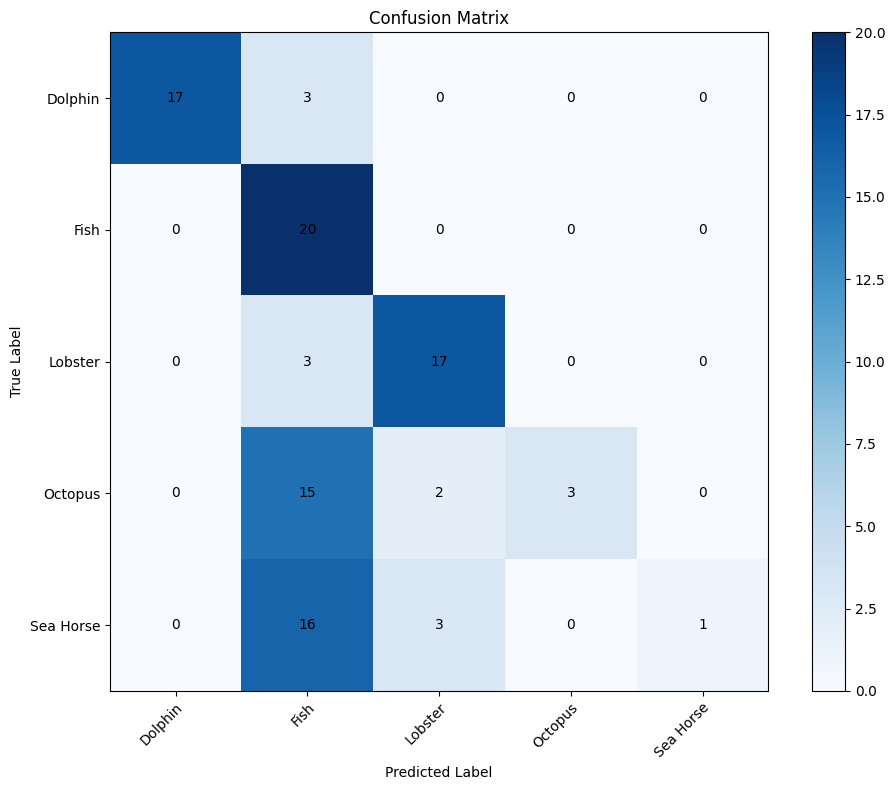

In [9]:
import numpy as np

# Manual prediction
y_pred = svm.predict(X_test_pca)

# Manual implementation of classification report
def manual_classification_report(y_true, y_pred, class_names):
    """Manual classification report without sklearn"""
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    report_lines = []
    
    # Calculate overall accuracy
    accuracy = np.mean(y_true == y_pred)
    
    report_lines.append("Classification Report:")
    report_lines.append(f"Overall Accuracy: {accuracy:.4f}")
    report_lines.append("")
    report_lines.append(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support':<10}")
    report_lines.append("-" * 55)
    
    for class_idx in unique_classes:
        # Calculate TP, FP, FN
        tp = np.sum((y_pred == class_idx) & (y_true == class_idx))
        fp = np.sum((y_pred == class_idx) & (y_true != class_idx))
        fn = np.sum((y_pred != class_idx) & (y_true == class_idx))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        support = np.sum(y_true == class_idx)
        
        class_name = list(class_names.keys())[list(class_names.values()).index(class_idx)]
        report_lines.append(f"{class_name:<15} {precision:.4f}     {recall:.4f}     {f1:.4f}      {support:<10}")
    
    return "\n".join(report_lines)

# Manual implementation of confusion matrix
def manual_confusion_matrix(y_true, y_pred, class_names):
    """Manual confusion matrix without sklearn"""
    unique_classes = sorted(np.unique(np.concatenate([y_true, y_pred])))
    n_classes = len(unique_classes)
    
    # Create confusion matrix
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for i, true_class in enumerate(unique_classes):
        for j, pred_class in enumerate(unique_classes):
            cm[i, j] = np.sum((y_true == true_class) & (y_pred == pred_class))
    
    return cm, unique_classes

def plot_manual_confusion_matrix(cm, class_names, unique_classes):
    """Manual confusion matrix plot without sklearn"""
    import matplotlib.pyplot as plt
    
    n_classes = len(unique_classes)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create heatmap
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    
    # Set labels
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    
    # Get class names in correct order
    display_labels = []
    for class_idx in unique_classes:
        for name, idx in class_names.items():
            if idx == class_idx:
                display_labels.append(name)
                break
    
    ax.set_xticklabels(display_labels)
    ax.set_yticklabels(display_labels)
    
    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    for i in range(n_classes):
        for j in range(n_classes):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    
    # Add colorbar
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

# Get class names from our manual generator
class_names = train_gen.class_indices

# Print manual classification report
print(manual_classification_report(y_test, y_pred, class_names))

# Create and plot manual confusion matrix
cm, unique_classes = manual_confusion_matrix(y_test, y_pred, class_names)
plot_manual_confusion_matrix(cm, class_names, unique_classes)

In [11]:
import pickle

def manual_model_save(pca_model, svm_model, pca_path, svm_path):
    """
    Manual implementation of joblib.dump for saving PCA and SVM models
    
    Parameters:
    pca_model: Trained PCA model
    svm_model: Trained SVM model
    pca_path: Path to save PCA model
    svm_path: Path to save SVM model
    """
    
    # Save PCA model manually
    pca_data = {
        'components': pca_model.components_,
        'mean': pca_model.mean_,
        'explained_variance': pca_model.explained_variance_,
        'n_components': pca_model.n_components_
    }
    
    with open(pca_path, 'wb') as pca_file:
        pickle.dump(pca_data, pca_file)
    
    # Save SVM model manually
    svm_data = {
        'support_vectors': svm_model.support_vectors_,
        'dual_coef': svm_model.dual_coef_,
        'intercept': svm_model.intercept_,
        'kernel': svm_model.kernel,
        'gamma': getattr(svm_model, '_gamma', 'scale'),
        'degree': svm_model.degree,
        'coef0': svm_model.coef0,
        'class_weight': svm_model.class_weight,
        'classes_': svm_model.classes_
    }
    
    with open(svm_path, 'wb') as svm_file:
        pickle.dump(svm_data, svm_file)
    
    print("Models saved successfully!")

def manual_model_load(pca_path, svm_path):
    """
    Manual implementation of joblib.load for loading PCA and SVM models
    
    Parameters:
    pca_path: Path to load PCA model from
    svm_path: Path to load SVM model from
    
    Returns:
    pca_model: Loaded PCA model
    svm_model: Loaded SVM model
    """
    
    # Load PCA model manually
    with open(pca_path, 'rb') as pca_file:
        pca_data = pickle.load(pca_file)
    
    # Create PCA model instance and restore attributes
    pca_model = PCA(n_components=pca_data['n_components'])
    pca_model.components_ = pca_data['components']
    pca_model.mean_ = pca_data['mean']
    pca_model.explained_variance_ = pca_data['explained_variance']
    
    # Load SVM model manually
    with open(svm_path, 'rb') as svm_file:
        svm_data = pickle.load(svm_file)
    
    # Create SVM model instance and restore attributes
    svm_model = SVC(
        kernel=svm_data['kernel'],
        gamma=svm_data['gamma'],
        degree=svm_data['degree'],
        coef0=svm_data['coef0'],
        class_weight=svm_data['class_weight']
    )
    svm_model.support_vectors_ = svm_data['support_vectors']
    svm_model.dual_coef_ = svm_data['dual_coef']
    svm_model.intercept_ = svm_data['intercept']
    svm_model.classes_ = svm_data['classes_']
    
    print("Models loaded successfully!")
    return pca_model, svm_model